# Importing Libraries

In [ ]:
import os
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler
import torch.utils.data as td


from typing import Type, Any, Callable, Union, List, Optional, cast
from collections import OrderedDict 

plt.rcParams["savefig.bbox"] = 'tight'

# Loading Data part

In [ ]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 32
norm_arr = ([0.5159, 0.5159, 0.5159], [0.2554, 0.2554, 0.2554])
num_workers = 12

import os
import torchvision.transforms as T
from torchvision import datasets
import torch.utils.data as td

class_names = []

def load_data(path, batch_size, input_size, norm_arr, 
              num_workers=0):
    
    transform_dict = {"train": 
                          T.Compose([
                            #T.ToPILImage(),
                            T.Resize(size=input_size),

                            T.RandomHorizontalFlip(),
                            #T.ColorJitter(contrast=0.5),
                            T.RandomAdjustSharpness(2),
                            T.RandomAutocontrast(),

                            T.ToTensor(),
                            T.Normalize(*norm_arr)]),
                        "test_val": 
                          T.Compose([
                            #T.ToPILImage(),
                            T.Resize(size=input_size),
                            T.ToTensor(),
                            T.Normalize(*norm_arr)])
                        }
    
    # train_dataset = datasets.ImageFolder(root=os.path.join(path, "train"),
    #                                      transform=transform_dict["train"])
    
    # class_names = train_dataset.classes
    # print(class_names)

    test_dataset = datasets.ImageFolder(root=os.path.join(path, "test"),
                                        transform=transform_dict["test_val"])
    
    # data_loader_train = td.DataLoader(train_dataset,
    #                                   batch_size=batch_size,
    #                                   shuffle=True,
    #                                   drop_last=False,
    #                                   num_workers=num_workers,
    #                                   pin_memory=True)
    data_loader_test = td.DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     drop_last=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

    return {
            'test':  data_loader_test}

In [ ]:
images_dir = "drive/MyDrive/covid_radiography"

In [ ]:
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = (256, 256), 
                         norm_arr = norm_arr,
                         num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Loading Saved Model

In [ ]:
# from utils file

from torchvision import models
import torch.nn as nn

def set_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=None):
    '''
    Initialize models for training.
    '''
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ 
            Returns a Resnet 50 model.
        """
        model_ft = models.resnet50(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 232
        
    elif model_name == "resnet34":
        """ 
            Returns a Resnet 34 model.
        """
        model_ft = models.resnet34(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "inceptionv3":
        """ 
            Returns an Inception v3 model.
        """
        model_ft = models.inception_v3(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        # Auxilary network.
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Primary network.
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
        
    elif model_name == "vgg16":
        """ 
            Returns a VGG 16 model with batch normalization.
        """
        model_ft = models.vgg16_bn(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "mobile_net_v3_large":
        """ 
            returns a mobile net V3 large model.
        """
        model_ft = models.mobilenet_v3_large(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 232

    elif model_name == "efficient_net_b1":
        """ 
            Returns an efficient net b1 model.
        """
        model_ft = models.efficientnet_b1(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 255

    elif model_name == "efficient_net_b0":
        """ 
            Returns an efficient net b0 model.
        """
        model_ft = models.efficientnet_b0(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 256

    else:
        print("Unavailable model selected.")

    return model_ft, input_size

In [ ]:
# parameters for model loading and data loading

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "resnet34"

# Number of classes.
num_classes = 3

# Covid Pneumonia dataset metrics
norm_arr = ([0.5159, 0.5159, 0.5159], [0.2554, 0.2554, 0.2554])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None

# Initialize the model for this run.
resnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)


In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
children_counter = 0
for n,c in resnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [ ]:
class NewModelResnet(nn.Module):
    def __init__(self, resnet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [7,8]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = resnet
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
resnet.load_state_dict(torch.load('drive/MyDrive/resnet34_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
resnetmodel = NewModelResnet(resnet)
resnetmodel = resnetmodel.to(device)

#T-SNE for Resnet

In [ ]:
f = 32
labels = []
outputs = []
for b, (image, label) in enumerate(data_loaders['test']):
            print(b,f)
            # Apply the model
            image, label = image.to(device), label.to(device)
            _, dictionary = resnetmodel(image)
            labels += label
            outputs += dictionary['layer4']
            f-=1
            if(f==0):
              break

0 32
1 31
2 30
3 29
4 28
5 27
6 26
7 25
8 24
9 23
10 22


RuntimeError: ignored

In [ ]:
image, label = next(iter(data_loaders['test']))

In [ ]:
outputs, dictionary = resnetmodel(image.cuda())

In [ ]:
layer4 = dictionary['layer4'].reshape(batch_size, 512*8*8)
layer4 = layer4.detach().cpu().numpy()

In [ ]:
layer4.shape

(256, 32768)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=10000).fit_transform(layer4)

In [ ]:
class1 = []
class2 = []
class3 = []

for i in range(len(X_embedded)):
  if(label[i]==0):
    class1.append(X_embedded[i])
  elif(label[i]==1):
    class2.append(X_embedded[i])
  elif(label[i]==2):
    class3.append(X_embedded[i])

class1 = np.array(class1)
class2 = np.array(class2)
class3 = np.array(class3)

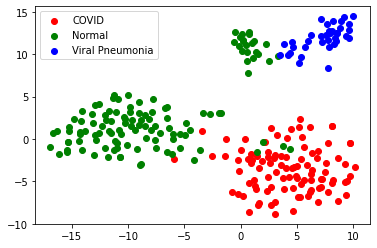

In [ ]:
plt.scatter(class1[:,0], class1[:,1], c="red", label="COVID")
plt.scatter(class2[:,0], class2[:,1], c="green", label="Normal")
plt.scatter(class3[:,0], class3[:,1], c="blue", label="Viral Pneumonia")
plt.legend()
plt.show()

# MobileNet

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "mobile_net_v3_large"

# Number of classes.
num_classes = 3

# Number of workers for data loader.
num_workers = 12

# Covid Pneumonia dataset metrics
norm_arr = ([0.5159, 0.5159, 0.5159], [0.2554, 0.2554, 0.2554])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None

# Initialize the model for this run.
mobilenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

In [ ]:
mobilenet

In [ ]:
children_counter = 0
for n,c in mobilenet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  features
Children Counter:  1  Layer Name:  avgpool
Children Counter:  2  Layer Name:  classifier


In [ ]:
class NewModelMobileNet(nn.Module):
    def __init__(self, mobilenet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [16]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = mobilenet
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules['features']._modules.keys())):
            print(i,l)
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained._modules['features'],l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
mobilenet.load_state_dict(torch.load('drive/MyDrive/mobile_net_v3_large_covid_pneumonia_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
mobilenetmodel = NewModelMobileNet(mobilenet)
mobilenetmodel.to(device)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16


NewModelMobileNet(
  (pretrained): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [ ]:
f = 5
labels = []
outputs = []
for b, (image, label) in enumerate(data_loaders['test']):
            print(b,f)
            # Apply the model
            image, label = image.to(device), label.to(device)
            _, dictionary = mobilenetmodel(image)
            labels += label
            outputs += dictionary['16']
            f-=1
            if(f==0):
              break

0 5
1 4
2 3
3 2
4 1


In [ ]:
for i in range(160):
  outputs[i] = outputs[i].cpu().detach().numpy()


In [ ]:
outputs = np.array(outputs)

In [ ]:
layer16 = torch.tensor(outputs)

In [ ]:
layer16 = layer16.reshape(batch_size*5, 960*8*8)
layer16 = layer16.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=100000).fit_transform(layer16)

In [ ]:
class1 = []
class2 = []
class3 = []

for i in range(len(X_embedded)):
  if(labels[i]==0):
    class1.append(X_embedded[i])
  elif(labels[i]==1):
    class2.append(X_embedded[i])
  elif(labels[i]==2):
    class3.append(X_embedded[i])

class1 = np.array(class1)
class2 = np.array(class2)
class3 = np.array(class3)

In [ ]:
class3

array([], dtype=float64)

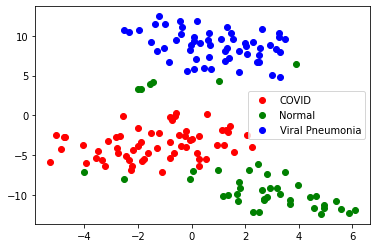

In [ ]:
plt.scatter(class1[:,0], class1[:,1],  c="red", label="COVID")
plt.scatter(class2[:,0], class2[:,1], c="green", label="Normal")
plt.scatter(class3[:,0], class3[:,1], c="blue", label="Viral Pneumonia")
plt.legend()
plt.show()